# importation + exploration

Dans cette partie nous allons importer toutes les billiotèque utiles a la pour réaliser notre pipeline. 

In [1]:
import streamlit as st
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime  

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC, SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier

import mlflow.sklearn
import mlflow
import torch
import flask 
import pickle
from varname import nameof

import xgboost
import shap
from tqdm import tqdm


from mlflow.models.signature import infer_signature

cleaned_data = pd.read_csv("../cleaned_data.csv")


Dans cette premiere partie nous allos tous simplement épurer le jeux de donnée. 

On supprime ici les données qui contionnent trop de NAN 

In [2]:
ratio_of_na = (cleaned_data.isna().sum())/cleaned_data["SK_ID_CURR"].count()
rest_nan_column = pd.Series(cleaned_data.columns[np.where((ratio_of_na<0.4)&(ratio_of_na>0))])
print(cleaned_data.isna().sum(axis=0).describe())


Ici on va venir découper notre jeu de données en 2 partie :
- les targets (y)
- les variables (x)

In [55]:
import plotly.express as px
import pandas as pd

# Sample DataFrame
data = {'x': [1, 2, 3, 4, 5],
        'y': [2, 4, 1, 3, 5],
        'value_column': [10, 20, 30, 40, 50]}

df = pd.DataFrame(data)

# Define the value that should trigger a color change
value_to_highlight = 30

# Create a boolean mask based on the value_column
mask = df['value_column'] == value_to_highlight
indices_to_highlight = mask[mask].index.tolist()
# Create the strip plot
fig = px.strip(df, x='x', y='y')

# Use the update_traces method to modify the color of specific points
fig.update_traces(marker=dict(color="red"), selector=indices_to_highlight)

TypeError: selector must be dict or a function accepting a graph object returning a boolean.

In [53]:
cleaned_data.columns.tolist()

['index',
 'SK_ID_CURR',
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUME

In [52]:
cleaned_data.loc[:,[col for col in cleaned_data.columns if 'FLAG' in col]].columns.tolist()


['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN']

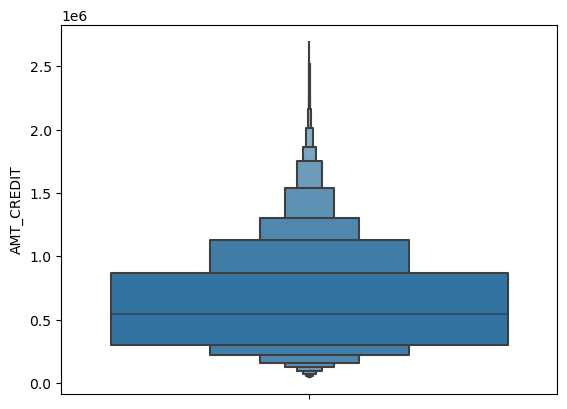

In [33]:
fig = sns.boxenplot(cleaned_data, y="AMT_CREDIT")


In [3]:
y = cleaned_data.loc[:,'TARGET']
X = cleaned_data.drop(columns='TARGET')

Je sépare maintenant mes deux jeux de donnée en train et test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train_head = X_train[:2000]
y_train_head = y_train[:2000]


Je vais les enregistrer pour pouvoir les utiliser plus tard.

In [5]:
X_train_head.to_csv('X_train.csv', index = False)
X_test.to_csv('X_test.csv', index = False)
y_train_head.to_csv('y_train.csv', index = False)

# Pipeline de pré processing

Dans cette partie on réalise le pipeline de pré processing

Je vais donc commencer par séparer mon jeu de donnée X en 2 grace a des filtres :
- les données numériques 
- les données catégorielles 

In [6]:
#
column_values_is_num = (X.dtypes==np.dtype('int64')) | (X.dtypes==np.dtype('float64'))
column_values_is_cat = (X.dtypes==np.dtype('O'))

# 
numerical_features_filter = pd.Series(X.columns[np.where(column_values_is_num)])
categorical_features_filter = pd.Series(X.columns[np.where(column_values_is_cat)])

# affichage du nombre de la quantitées 
print('column_values_is_num : ' + str(numerical_features_filter.count()))
print('column_values_is_cat : ' + str(categorical_features_filter.count()))

Puis je vais créer un pipeline pour chaque 

In [7]:
numeric_transformer = Pipeline(steps=[("standar_scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("encoder",OneHotEncoder(handle_unknown = 'ignore'))])


Et je vais apliquer de la sorte : 

- Pour les données numériques, un standar_scaler
- Pour les données catégorielles, un encoder

In [8]:
features_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features_filter),
        ("cat", categorical_transformer, categorical_features_filter)
    ],
    sparse_threshold=0
)

SMOTE & Preprocessed 

In [9]:
smote = SMOTE(random_state=42)

# création de fonction utiles

## fonction print dataframe 

Cette fonction permmet le bel affichage des données 

In [10]:
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, params in zip(
        filtered_cv_results["mean_test_score"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.8f}),"
            f" for {params}"
        )
    print()

## fonction refit

Cette fonction permet de selectionner exclusivement les paramettres corespondant à certains critères (rate of change - Auc = 0.82)

In [11]:
def refit(cv_results): 
    roc_auc_limit = 0.82
    result_roc_auc= cv_results["mean_test_score"]
    params= cv_results["params"]    
    columns_to_keep = list()
    for mean_precision, param_dict in zip(
        result_roc_auc,
        params):
        if mean_precision > roc_auc_limit :
            filtered_params = {key: [value] for key, value in param_dict.items()}
            columns_to_keep.append(filtered_params)
    return(columns_to_keep)


## fonction Métier

Cette fonction permet le de calculer le score métier

In [12]:
def fonction_metier(y_test, y_pred, **kwargs): 
    cm = confusion_matrix(y_test, y_pred)
    faux_positif = cm[1][0]
    faux_negatif = cm[0][1]
    result = 1*faux_negatif + 10*faux_positif
    return(result)


création du score métier 

In [13]:
custom_scorer = make_scorer(fonction_metier, greater_is_better=False)

## fonction find_thresh_prob

Cette fonction permet de trouver le meilleur seuil de probabilité pour une valeur metier donnée

In [14]:
def find_thresh_prob(model):
    
    # initialisation
    threshold_list = [n/100 for n in range(1, 100)]
    list_of_the_bus_val = list()
    best_bus_val = 0
    best_threshold = 0
    best_y_pred_threshold = None
    
    # Création de la boucle qui calcule chaque seuil:
    for i, seuil in enumerate(threshold_list):
        
        # Prédiction
        y_pred_threshold = (model.predict_proba(X_test)[:,1] >= seuil).astype(int)
        cm = confusion_matrix(y_test, y_pred_threshold)
        bus_val = fonction_metier(y_test, y_pred_threshold)
        
        # Prend le meilleur seuil. 
        if (best_bus_val == 0)|(best_bus_val > bus_val): 
            best_threshold = seuil
            best_bus_val = bus_val
            best_y_pred_threshold = y_pred_threshold
        list_of_the_bus_val.append(bus_val)
    bus_result = pd.DataFrame({'threshold_list': threshold_list, 'list_of_the_bus_val': list_of_the_bus_val})
    
    # retourne plein de choses très utiles
    return(bus_result, best_y_pred_threshold, best_threshold, best_bus_val)

## Fonction qui fais la matrice des coocurence

Cette fonction permet de faire la matrice de coocurence 

In [15]:
def show_coo_matrix(model, best_threshold):
    y_pred_good_threshold = (model.predict_proba(X_test)[:,1] >= best_threshold).astype(int)
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred_good_threshold))
    ax= plt.subplot()
    
    #création de la Heatmap
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 

## Fonction save model

Ces deux fonctions me permette respectivement de : 
- Sauver le pipeline sous forme d'un .pkl 
- Sauver les paramettre utile au modele en temps voulus

In [16]:
def save_model(model):
    # télécharge le modele en fichier
    with open('mlflow_model/best_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    file.close()


def logs_params(classif, parameter, roc_auc, accuracy, best_bus_val, best_threshold):        
    with mlflow.start_run():
        mlflow.log_param("parameters", parameter)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("best_bus_val", best_bus_val)
        mlflow.log_metric("best_threshold", best_threshold)
        mlflow.set_tracking_uri("file:///path/to/mlruns")    
        mlflow.end_run()
    
    print(mlflow.get_artifact_uri()) 
    print(mlflow.get_tracking_uri())

## Fonction create and exe pipeline

Cette fonction crée un pipeline ayant cette forme :  

![the pipeline form](pics/pipeline.png)

Et l'entraine!!

In [17]:
def create_and_exe_pipeline(classifier, parameters, scoring): 
    gridsearchcv = GridSearchCV(classifier, parameters, scoring=scoring)
    model = Pipeline(steps=[
        ('transformer', features_transformer),  
        ('smote', smote),  
        ('gridsearch', gridsearchcv)])
    model.fit(X_train_head, y_train_head)
    return(model, gridsearchcv)

# Création et entrainement du pipeline

## Preprossess

commencons par créer: 
1. la liste contenant les différents classifier

In [18]:
max_iteration = np.ceil(10**6/y_train_head.shape[0]).astype(int)
classifier_list = [SGDClassifier(loss="log_loss", penalty="l2", max_iter=max_iteration),
                  DecisionTreeClassifier(random_state=0),
                  LGBMClassifier()]

In [19]:
str(classifier_list[0])

2. Puis celle contenant les différents paramètres pour chacun d'eux

In [20]:

sgd_parameters = {'alpha':[0.001, 0.01, 0.1],
                  'tol' : [0.01, 0.1, 1]}

dtc_parameters = {'criterion':["gini", "entropy", "log_loss"],
                  'max_depth': np.arange(3, 15, 2)}

lgbm_parameters = {'min_data_in_leaf': [400, 500],
                   'n_estimators': [200, 250],
                   'lambda_l1': [0, 1, 1.5],
                   'lambda_l2': [0, 1],
                   'subsample' : [1],
                   'max_depth' : [-1, 5, 10]}


# la liste contenant tous les paramètres
parameter_list = [sgd_parameters,
                  dtc_parameters,
                  lgbm_parameters]

nous allons enfin executer le modele en trois étapes :
1. Création du pipeline avec un gridsearch basé sur le roc auc et entrainement du modele
2. Refiting des hyper paramètres avec roc_auc > 0,82
3. Création du pipeline avec un gridsearch basé sur le score métier et entrainement du modele
4. trouver le meilleur seuil de probabilité

In [21]:
best_result_list = list()

for (classif,param) in zip(classifier_list, parameter_list):
    # Création du pipeline avec un gridsearch basé sur le roc auc  
    # et entrainement du modele:
    print("###################")
    print(classif)
    print("###################")
    print("Parametres" + str(param))
    
    model, gscv = create_and_exe_pipeline(classif, param, "roc_auc")
    print("premier pipeline fini\n")

    # Refiting des hyper paramètre : 
    bus_param = refit(gscv.cv_results_)
    
    print("refit fini: \n")
    print(bus_param)
    print("\n")

    # Création du pipeline avec un gridsearch basé sur le score métier 
    # et entrainement du modele:
    bus_model, bus_gscv = create_and_exe_pipeline(classif, bus_param, custom_scorer)
    
    print("deuxieme pipeline fini")
    print("\n")
    
    # Cherchons maintenant le meilleur seuil: 
    bus_result, y_pred, best_threshold, best_bus_val = find_thresh_prob(bus_model)
    print("recherche su meilleur seuil fini")
    print("\n")
    
    #on calcule la précision (accuracy): 
    accuracy = accuracy_score(y_test, y_pred)

    # On enregistre les meilleurs parametres
    mlflow.end_run()
    logs_params(classif,
            gscv.best_params_,
            gscv.best_score_,
            accuracy,
            best_bus_val,
            best_threshold)
    print("enregistrement des parametres réalisé")
    print("\n")
    
    best_result_list.append([bus_gscv.best_params_,
                             best_bus_val,
                             bus_model,
                             bus_gscv,
                             best_threshold,
                             accuracy])

In [ ]:
show_coo_matrix(best_result_list[2][2], best_result_list[2][4])

nous allons maintenant récupérer le meilleur estimateur et faire la signature du modèle

In [ ]:
save_model(best_result_list[2][3].best_estimator_) 


In [ ]:
signature = infer_signature(X_train, y_train)

## Interpretation locale


Faisons maintenant l'interprétation locale du modele 

In [ ]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['mauvais client', 'bon client'],
    mode='classification'
)

In [ ]:
X_test_scaled = numeric_transformer.fit_transform(X_test) # scale data to reflect train time scaling
idx = 160905

exp = explainer.explain_instance(
    data_row=np.array(X_test.loc[X_test["SK_ID_CURR"] == 160905])[0], 
    predict_fn=best_result_list[2][3].best_estimator_.predict_proba)
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()[0]

## Interpretation globale

réalisation d'un xgboost pour vérifier les parametre les plus 

In [ ]:
explainer = shap.Explainer(best_result_list[2][3].best_estimator_)
explainer

In [ ]:
X_test.columns

In [ ]:
shap.summary_plot(explainer.shap_values(X_test), X_test)


## Data Drift 

In [ ]:
from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset
from evidently.test_preset import DataQualityTestPreset

In [ ]:
data_stability= TestSuite(tests=[
    DataStabilityTestPreset(),
])
print("premiere partie faite")
data_stability.run(current_data=X_test, reference_data=X_train, column_mapping=None)
data_stability 

In [ ]:
data_stability.save_html("file.html")


In [ ]:
from sklearn import datasets
iris_data = datasets.load_iris()
iris_frame = iris_data.frame
type(iris_frame)